# Exercise 1

In [1]:
using Pkg
Pkg.add("StatsBase")

    Updating registry at `/opt/julia/registries/General`
   Resolving package versions...
   Installed Qt5Base_jll ─── v5.15.3+1
   Installed Ogg_jll ─────── v1.3.5+1
   Installed libvorbis_jll ─ v1.3.7+1
   Installed MKL_jll ─────── v2021.1.1+2
   Installed GLFW_jll ────── v3.3.5+1
   Installed Glib_jll ────── v2.68.3+2
   Installed Libffi_jll ──── v3.2.2+1
   Installed StatsBase ───── v0.33.14
   Installed LERC_jll ────── v3.0.0+1
   Installed Libtiff_jll ─── v4.3.0+1
    Updating `/opt/julia/environments/v1.6/Project.toml`
  [2913bbd2] + StatsBase v0.33.14
    Updating `/opt/julia/environments/v1.6/Manifest.toml`
  [2913bbd2] ↑ StatsBase v0.33.10 ⇒ v0.33.14
  [0656b61e] ↑ GLFW_jll v3.3.5+0 ⇒ v3.3.5+1
  [7746bdde] ↑ Glib_jll v2.68.3+0 ⇒ v2.68.3+2
  [88015f11] + LERC_jll v3.0.0+1
  [e9f186c6] ↑ Libffi_jll v3.2.2+0 ⇒ v3.2.2+1
  [89763e89] ↑ Libtiff_jll v4.3.0+0 ⇒ v4.3.0+1
  [856f044c] ↑ MKL_jll v2021.1.1+1 ⇒ v2021.1.1+2
  [e7412a2a] ↑ Ogg_jll v1.3.5+0 ⇒ v1.3.5+1
  [ea2cea3b] ↑ Qt5Base_

## 1. Generating exponentially distributed random variables

Let us simulate $10^5$ realizations of a random variable $X$ that follows an Exponential distribution of parameter $\lambda = 10$. 

- with the uniform distribution

In [2]:
λ = 10
g = y -> -log(y)/λ                       # write what your function should return here
u = rand(100000)                         # draw 10^5 realizations from a uniform distribution with rand()e
g_eval = g.(u);                          # evaluate your function g at those realizations

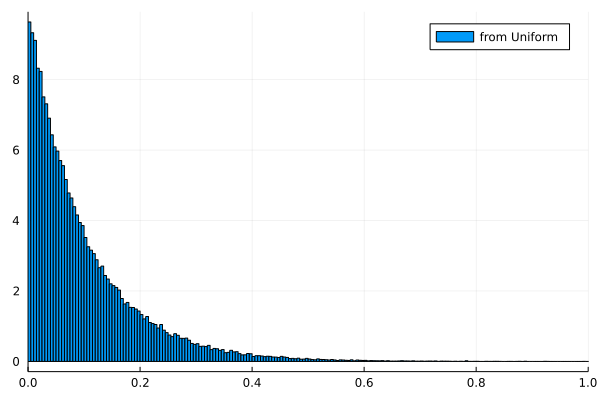

In [3]:
using Plots
histogram(g_eval, normalize = true, xlim = (0, 1), label = "from Uniform")
#histogram(u, normalize = true, xlim = (0, 1), label = "from Uniform")

- with the exponential distribution

[1]https://github.com/JuliaStats/Distributions.jl/tree/ebeab79ff28f144506f6aa51b284b67486283ba0/src/univariate/continuous
[2]https://github.com/JuliaLang/julia/blob/master/stdlib/Random/src/normal.jl

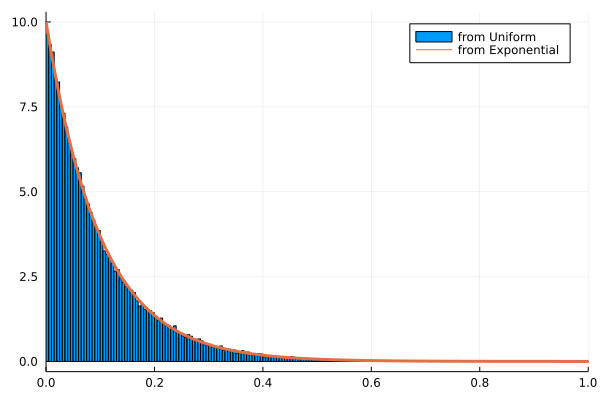

In [4]:
using Distributions
pdf_evaluation = x -> pdf.(Exponential(1/λ), x)
plot!(0:0.01:2.0, pdf_evaluation, 
    linewidth = 3.0, 
    label = "from Exponential")

## 2. Gillespie algorithm (naive implementation)

In [5]:
κ = 0.01        # rate constant
x₀ = 20         # initial count of molecules
Δt = 0.001;  

In [6]:
gillespie_alg_naive = function(x₀, κ, Δt, stoptime)
   

    tt = zeros(Integer(round(stoptime/Δt))+1)
    xx = Integer.(zeros(length(tt)))
   
    t = 0
    k = 0
    
    xx[1] = x₀                      # initial count
    tt[1] = t                       # initial time
    
    k = 1
    while (t < stoptime)
        x = xx[k]
        
        # step 1
        ν = x*κ*Δt
        # step 2
        u = rand()
        # step 3
        u < ν ? xx[k+1] = x - 1 : xx[k+1] = x
        
        t = k*Δt
        tt[k+1] = t
        k = k + 1 
    end
    
    return tt, xx
end;

In [7]:
tt, xx = gillespie_alg_naive(x₀, κ, Δt, 30);

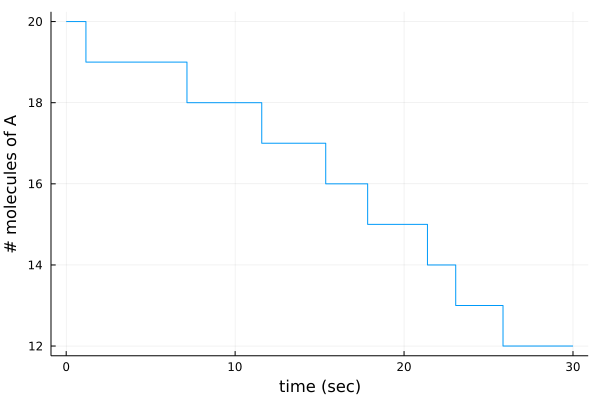

In [8]:
plot(tt, xx, linetype=:steppre, xlabel = "time (sec)", ylabel = "# molecules of A", legend=false)

## 3. Gillespie algorithm

### Preliminary steps

Let us consider the reactions

$A \xrightarrow{\kappa_1} \emptyset$

$\emptyset \xrightarrow{\kappa_2}A $

\begin{align}
(\text{Reactants})\,\underline{S} = \begin{bmatrix}
n_{A,\,r_1}^{(\text{reac})}\\
n_{A,\,r_2}^{(\text{reac})}\\
\end{bmatrix}_{\text{#reactions }\times \text{ #species}} &= \begin{bmatrix}
1\\
0\\
\end{bmatrix}\\
\hspace{2cm}
(\text{Products})\,\overline{S} = \begin{bmatrix}
n_{A,\,r_1}^{(\text{prod})}\\
n_{A,\,r_2}^{(\text{prod})}\\
\end{bmatrix}_{\text{#reactions }\times \text{ #species}} &= \begin{bmatrix}
0\\
1\\
\end{bmatrix}
\end{align}

\begin{align}
(\text{Stoichiometric Matrix})\, S = (\overline{S} - \underline{S})^\top = \begin{bmatrix}
-1 & 1
\end{bmatrix}
\end{align}



In [9]:
# Number of reactions
Nᵣ = 2

# Compute the stoichiometric matrix 
Products = [0; 1]
Reactants = [1; 0]
SM = (Products - Reactants)'

1×2 adjoint(::Vector{Int64}) with eltype Int64:
 -1  1

(step 1) Compute the propensity function $\nu_{n_r}(t)$ for each of the $N_r$ reactions. Then compute the total propensity  $\alpha(t)$.

In [10]:
# Compute the propensity function for each of the reactions

V = 0.001                                       # Volume 
ν₁ =  function(κ₁, x) return κ₁*x[1] end            # Propensity function for degradation
ν₂ = function(κ₂, x) return κ₂*V end             # Propensity function for production

#9 (generic function with 1 method)

In [11]:
# Compute the total propensity
propensities = function(k, x, ν, Nᵣ)
    ν_eval = zeros(Nᵣ)
    for r in 1:Nᵣ
        ν_eval[r] = ν[r](k[r], x) 
    end
    return ν_eval
end

#11 (generic function with 1 method)

In [12]:
# Example : 
k = [0.1, 1000]
x = [0]
ν = [ν₁, ν₂]

ν_eval = propensities(k, x, ν, 2)                                  # Evaluate propensity functions 

2-element Vector{Float64}:
 0.0
 1.0

In [13]:
α = sum(ν_eval)

1.0

(step 2) Compute the time when the first chemical reaction takes place as $\tau$, where $\tau$ is sampled from an exponential distribution with parameter $\alpha(t)$

In [14]:
τ = rand(Exponential(1/α))                                     

2.4397891544092207

(step 3) Find out which reaction occurs at time $\tau$

In [15]:
using StatsBase
index_j = StatsBase.sample(1:2, Weights(ν_eval./α));
println("Reaction n." .* string(index_j) .* " takes place!")

Reaction n.2 takes place!


In [16]:
println("Update number of molecules A with the stoichiometric vector: " .* string(SM[:, index_j]))

Update number of molecules A with the stoichiometric vector: [1]


### Gillespie algorithm (main algorithm)

Combine all these steps in a loop.

In [17]:
gillespie_alg = function(SM, κ, ν, x₀, stoptime)
    t = 0.0
    x = x₀
    
    Nₛ, Nᵣ = size(SM)
    
    tt = [t]
    xx = copy(x)     
    
    k=1
    
    while (t <= stoptime)
        
        # step 1
        ν_eval = propensities(κ, x, ν, Nᵣ)              
        α = sum(ν_eval) 

        # step 2
        τ = rand(Exponential(1/α))                                   
        t += τ

        # step 3
        index_j = StatsBase.sample(1:Nᵣ, Weights(ν_eval./α))
        
        x = x + SM[:, index_j]
        append!(tt, t)
        xx = cat(xx, x, dims=2)
    end
    
    return tt, xx'
end

#13 (generic function with 1 method)

### (a) Stochastic simulation of degradation

In [19]:
# Number of reactions Nᵣ = 1
# Compute the stoichiometric matrix 
Products = [0]
Reactants = [1]
SM = (Products-Reactants)'

1×1 adjoint(::Vector{Int64}) with eltype Int64:
 -1

In [20]:
# Compute the propensity function for each of the reactions
V = 0.001
ν₁ =  function(κ₁, x) return κ₁*x[1] end

#15 (generic function with 1 method)

1 realization

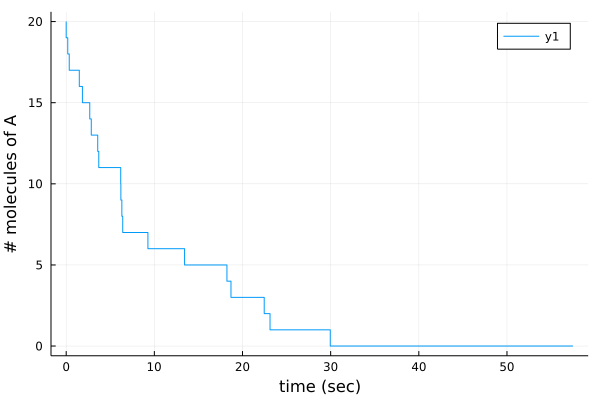

In [21]:
tt, xx = gillespie_alg(SM, [0.1], [ν₁], [20], 100.0)
plot(tt[1:end-1], xx[1:end-1], linetype=:steppre, xlabel="time (sec)", ylabel ="# molecules of A")

20 realizations

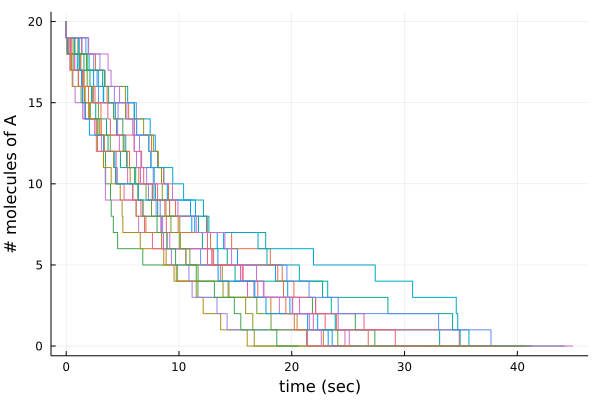

In [22]:
Nₛ = 20
p = plot(legend = false, xlabel = "time (sec)", ylabel = "# molecules of A")
for nₛ in 1:Nₛ    
    tt, xx = gillespie_alg(SM, [0.1], [ν₁], [20], 100.0)
    plot!(tt[1:end-1], xx[1:end-1], linetype=:steppre)
end
p

### (b) stochastic simulation of production and degradation

In [23]:
# Number of reactions Nᵣ = 2
# Compute the stoichiometric matrix 
Products = [0; 1]
Reactants = [1; 0]
SM = (Products-Reactants)'

1×2 adjoint(::Vector{Int64}) with eltype Int64:
 -1  1

In [24]:
# Compute the propensity function for each of the reactions
V = 0.001
ν₁ =  function(κ₁, x) return κ₁*x[1] end
ν₂ = function(κ₂, x) return κ₂*V end 

#19 (generic function with 1 method)

1 realization

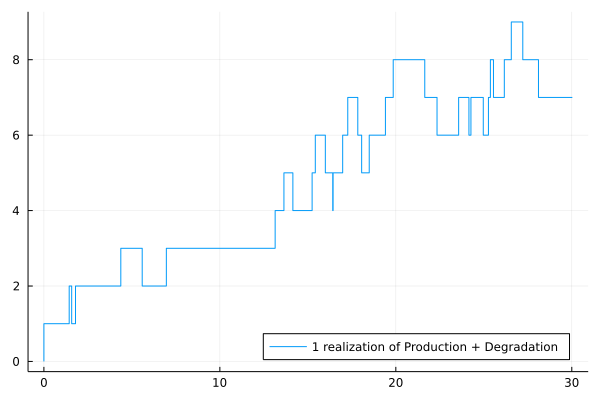

In [25]:
κ₁ = 0.1
κ₂ = 1000.0

tt, xx = gillespie_alg(SM, [κ₁, κ₂], [ν₁, ν₂], [0], 30.0)
plot(tt, xx, linetype=:steppre, label = "1 realization of Production + Degradation", legend=:bottomright)

10 realizations

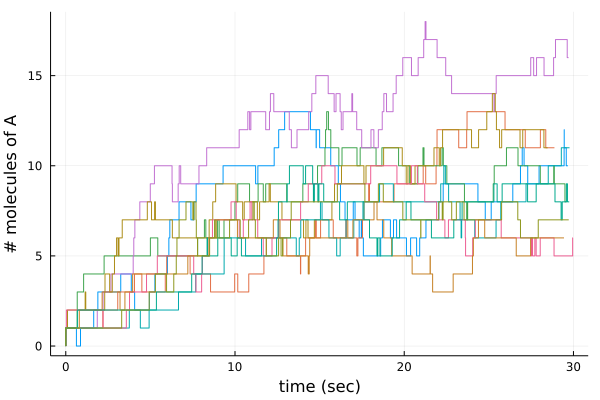

In [26]:
Nₛ = 10
p = plot(legend=false, xlabel="time (sec)", ylabel ="# molecules of A")
for nₛ in 1:Nₛ    
    tt, xx = gillespie_alg(SM, [κ₁, κ₂], [ν₁, ν₂], [0], 30.0)
    plot!(tt[1:end-1], xx[1:end-1], linetype=:steppre)
end
p

Evolution of the stochastic mean $M(t)$

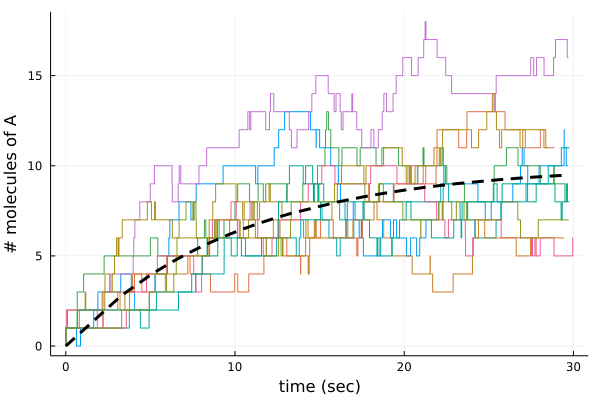

In [27]:
M₀ = 0
M = t -> κ₂*V/κ₁ + (M₀ - κ₂*V/κ₁)*exp(-κ₁*t)
plot!(tt[1:end-1], M, linestyle = :dash, colour = :black, linewidth = 3)

### (c) Steady-state version of the chemical master equation

Number of molecules at $t=100$sec, from $10^5$ realizations

In [33]:
N = 1e5                     #number of realisations
n_upperbound = 24
p = zeros(n_upperbound+1)   #vector of probabilities


for n in 1:N   
    tt, xx = gillespie_alg(SM, [κ₁, κ₂], [ν₁, ν₂], [0], 50.0)
    A = xx[end]    
    if (A <= n_upperbound) 
        p[xx[end]+1] += 1
    end
end

p /= N;

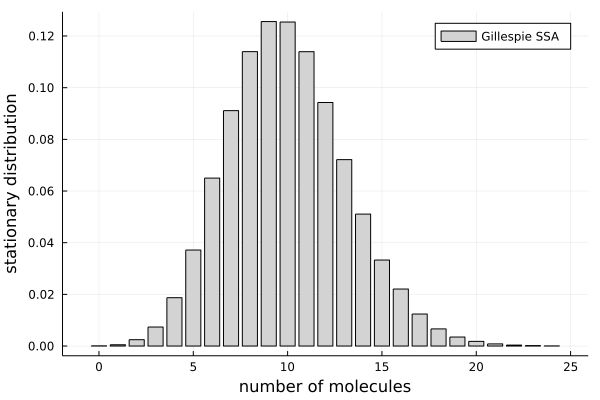

In [34]:
bar(collect(0:24), p, 
    colour = :lightgrey,
    label = "Gillespie SSA",
    xlabel = "number of molecules",
    ylabel = "stationary distribution")

In [35]:
compute_ϕ = function(n_upperbound, κ₁, κ₂)
    
    ϕ = zeros(n_upperbound+1)

    ϕ[1] =  1.0
    ϕ[2] =  κ₂*V/κ₁ * ϕ[1];

    for n in 1:n_upperbound-1
       ϕ[n+2] = (κ₁*n*ϕ[n+1] + κ₂*V*ϕ[n+1] - κ₂*V*ϕ[n])/(κ₁*(n+1));
    end
    return ϕ./(sum(ϕ))
end

#25 (generic function with 1 method)

In [36]:
ϕ = compute_ϕ(n_upperbound, 0.1, 1000.0);

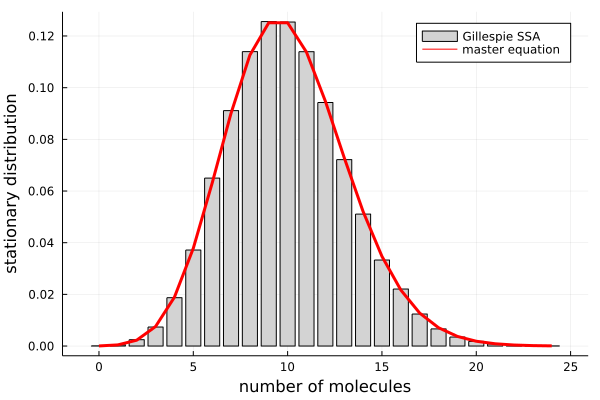

In [37]:
plot!(collect(0:n_upperbound), ϕ,
    linewidth = 3,
    colour = :red,
    label = "master equation")